# Random Forest Clasificación

## Datos

In [1]:
import pandas as pd
import numpy as np

In [2]:
carseats = pd.read_csv('Carseats.csv')
data = carseats.iloc[:,1:]
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


El set de datos Carseats, contiene información sobre la venta de sillas infantiles en 400 tiendas distintas. Para cada una de las 400 tiendas se han registrado 11 variables. Se pretende generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Sales > 8) o bajas (Sales <= 8) en función de todas las variables disponibles.  
Como Sales es una variable continua y el objetivo del estudio es clasificar las tiendas según si venden mucho o poco, se crea una nueva variable binaria (0, 1) llamada ventas_altas.

In [3]:
data['ventas_altas'] = np.where(data.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = data.iloc[:, 1:]

## Ajuste Del Modelo Y Optimización De Hiperparámetros

Se ajusta un árbol de clasificación empleando como variable respuesta ventas_altas y como predictores todas las variables disponibles. Se utilizan en primer lugar los hiperparámetros max_depth=5 y criterion='gini' , el resto se dejan por defecto. Después, se aplica el proceso de pruning y se comparan los resultados frente al modelo inicial.  
  
A diferencia del ejemplo anterior, en estos datos hay variables categóricas por lo que, antes de entrenar el modelo, es necesario aplicar one-hot-encoding. 


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [5]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(datos.drop(columns = 'ventas_altas'),
                                                    datos['ventas_altas'],
                                                    random_state = 123)


# One-hot-encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()


# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                                 remainder='passthrough')


# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

El resultado devuelto por ColumnTransformer es un numpy array , por lo que se pierden los nombres de las columnas. Es interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe . Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético.

In [6]:
# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.head()

D:\Documentos\Programas\Miniconda3\envs\Entorno01\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,128.0,39.0,12.0,356.0,118.0,71.0,10.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,118.0,83.0,13.0,276.0,104.0,75.0,10.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,110.0,119.0,0.0,384.0,97.0,72.0,14.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,132.0,68.0,0.0,264.0,123.0,34.0,11.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,122.0,35.0,2.0,393.0,136.0,62.0,18.0


Si bien RandomForestClassifier tiene valores por defecto para sus hiperparámetros, no se puede saber de antemano si estos son los más adecuados, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.  
  
Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada, que es computacionalmente costosa. En la implementación de RandomForestClassifier , la métrica devuelta como oob_score es el accuracy, si se desea otra, se tiene que recurrir al método oob_decision_function_() para obtener las predicciones y con ellas calcular la métrica de interés. Para una explicación más detallada consultar: Grid search de modelos Random Forest con out-of-bag error y early stopping. Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.  
  
Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros. 

## Grid Search Basado En Out-Of-Bag Score

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

In [8]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid( {'n_estimators': [150], 
                             'max_features': [5, 7, 9], 
                             'max_depth' : [None, 3, 10, 20], 
                             'criterion' : ['gini', 'entropy']
                            })


# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    modelo = RandomForestClassifier(oob_score = True,
                                    n_jobs = -1,
                                    random_state = 123,
                                    ** params)
    
    modelo.fit(X_train_prep, y_train)
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

    

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterio

,oob_accuracy,criterion,max_depth,max_features,n_estimators
18,0.836667,entropy,10.0,5,150
0,0.830000,gini,NaN,5,150
9,0.830000,gini,20.0,5,150
21,0.826667,entropy,20.0,5,150


In [9]:
import multiprocessing

In [10]:
# # VERSIÓN PARALELIZADA
# # ==============================================================================
# # Loop para ajustar un modelo con cada combinación de hiperparámetros
# # ==============================================================================
# param_grid = ParameterGrid( {'n_estimators': [150], 
#                              'max_features': [5, 7, 9], 
#                              'max_depth' : [None, 3, 10, 20], 
#                              'criterion' : ['gini', 'entropy']
#                             })


# # Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# # ==============================================================================
# def eval_oob_error(X, y, modelo, params, verbose=True):
#     """
#     Función para entrenar un modelo utilizando unos parámetros determinados
#     y que devuelve el out-of-bag error
#     """
#     modelo.set_params(oob_score = True,
#                       n_jobs = -1,
#                       random_state = 123,
#                       ** params)
    
#     modelo.fit(X, y)
#     if verbose:
#         print(f"Modelo: {params} \u2713")
    
#     return{'params': params, 'oob_accuracy': modelo.oob_score_}


# n_jobs = multiprocessing.cpu_count() -1
# pool = multiprocessing.Pool(processes=n_jobs)
# resultados = pool.starmap(eval_oob_error,
#                           [(X_train_prep, y_train, RandomForestClassifier(), params) for params in param_grid])
# # Resultados
# # ==============================================================================
# resultados = pd.DataFrame(resultados)
# resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
# resultados = resultados.drop(columns = 'params')
# resultados = resultados.sort_values('oob_accuracy', ascending=False)
# resultados.head(4)

In [11]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print("--------------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_accuracy'], "accuracy")

--------------------------------------------------
Mejores hiperparámetros encontrados (oob-accuracy)
--------------------------------------------------
0.8366666666666667 : 0.8366666666666667 accuracy


## Grid Search Basado En Validación Cruzada

In [12]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [13]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth' : [None, 3, 10, 20],
              'criterion' : ['gini', 'entropy']
             }



# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(estimator = RandomForestClassifier(random_state = 123),
                    param_grid = param_grid,
                    scoring = 'accuracy',
                    n_jobs = multiprocessing.cpu_count() - 1,
                    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
                    refit = True,
                    verbose = 0,
                    return_train_score = True
                   )

grid.fit(X = X_train_prep, y = y_train)


# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
.drop(columns = 'params') \
.sort_values('mean_test_score', ascending = False) \
.head(4)

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
12,entropy,None,5,150,0.813333,0.037118,1.0,0.0
21,entropy,20,5,150,0.813333,0.037118,1.0,0.0
9,gini,20,5,150,0.811111,0.038329,1.0,0.0
0,gini,None,5,150,0.811111,0.038329,1.0,0.0


In [14]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} : 0.8133333333333334 accuracy


Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True , este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_ .

In [15]:
modelo_final = grid.best_estimator_

## Predicción Y Evaluación Del Modelo

Por último, se evalúa la capacidad predictiva del modelo final empleando el conjunto de test.

In [16]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X = X_test_prep)
predicciones[:10]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [18]:
mat_confusion = confusion_matrix(y_true = y_test,
                                 y_pred = predicciones)

accuracy = accuracy_score(y_true = y_test,
                          y_pred = predicciones,
                          normalize = True)


print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[33 17]
 [ 5 45]]

El accuracy de test es: 78.0 %


In [19]:
print(
classification_report(y_true = y_test,
                      y_pred = predicciones
                     )
)

              precision    recall  f1-score   support

           0       0.87      0.66      0.75        50
           1       0.73      0.90      0.80        50

    accuracy                           0.78       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.78      0.78       100



Tras optimizar los hiperparámetros, se consigue un porcentaje de acierto del 78%.

## Predicción De Probabilidades

La mayoría de implementaciones de Random Forest, entre ellas la de scikit-learn, permiten predecir probabilidades cuando se trata de problemas de clasificación. Es importante entender cómo se calculan estos valores para interpretarlos y utilizarlos correctamente.  
  
En el ejemplo anterior, al aplicar .predict() se devuelve (ventas elevadas) o (ventas bajas) para cada observación de test. Sin embargo, no se dispone de ningún tipo de información sobre la seguridad con la que el modelo realiza esta asignación. Con .predict_proba() , en lugar de una clasificación, se obtiene la probabilidad con la que el modelo considera que cada observación puede pertenecer a cada una de las clases.

In [20]:
# Predicción de probabilidades
# ==============================================================================
predicciones = modelo_final.predict_proba(X = X_test_prep)
predicciones[:5, :]

array([[0.76666667, 0.23333333],
       [0.66      , 0.34      ],
       [0.89333333, 0.10666667],
       [0.73333333, 0.26666667],
       [0.72666667, 0.27333333]])

El resultado de .predict_proba() es un array con una fila por observación y tantas columnas como clases tenga la variable respuesta. El valor de la primera columna se corresponde con la probabilidad, acorde al modelo, de que la observación pertenezca a la clase 0, y así sucesivamente. El valor de probabilidad mostrado para cada predicción se corresponde con la fracción de observaciones de cada clase en los nodos terminales a los que ha llegado la observación predicha en el conjunto de los árboles.  
  
Por defecto, .predict() asigna cada nueva observación a la clase con mayor probabilidad (en caso de empate se asigna de forma aleatoria). Sin embargo, este no tiene por qué ser el comportamiento deseado en todos los casos.

In [21]:
# Clasificación empleando la clase de mayor probabilidad
# ==============================================================================
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])

df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)

df_predicciones.head(3)

,0,1,clasificacion_default_0.5
0,0.766667,0.233333,0
1,0.660000,0.340000,0
2,0.893333,0.106667,0


Supóngase el siguiente escenario: la campaña de navidad se aproxima y los propietarios de la cadena quieren duplicar el stock de artículos en aquellas tiendas de las que se preve que tengan ventas elevadas. Como el transporte de este material hasta las tiendas supone un coste elevado, el director quiere limitar esta estrategia únicamente a tiendas para las que se tenga mucha seguridad de que van conseguir muchas ventas.  
  
Si se dispone de las probabilidades, se puede establecer un punto de corte concreto, por ejemplo, considerando únicamente como clase (ventas altas) aquellas tiendas cuya predicción para esta clase sea superior al 0.9 (90%). De esta forma, la clasificación final se ajusta mejor a las necesidades del caso de uso.

In [22]:
# Clasificación final empleando un threshold de 0.8 para la clase 1.
# ==============================================================================
df_predicciones['clasificacion_custom_0.8'] = np.where(df_predicciones['1'] > 0.9, 1, 0)

df_predicciones.iloc[4:10, :]

,0,1,clasificacion_default_0.5,clasificacion_custom_0.8
4,0.726667,0.273333,0,0
5,0.613333,0.386667,0,0
6,0.180000,0.820000,1,0
7,0.366667,0.633333,1,0
8,0.140000,0.860000,1,0
9,0.246667,0.753333,1,0


## ¿Hasta que punto se debe de confiar en estas probabilidades?

Es muy importante tener en cuenta la diferencia entre la "visión" que tiene el modelo del mundo y el mundo real. Todo lo que sabe un modelo sobre el mundo real es lo que ha podido aprender de los datos de entrenamiento y, por lo tanto, tiene una "visión" limitada. Por ejemplo, supóngase que, en los datos de entrenamiento, todas las tiendas que están en zona urbana Urban='Yes' tienen ventas altas independientemente del valor que tomen el resto de predictores. Cuando el modelo trate de predecir una nueva observación, si esta está en zona urbana, clasificará a la tienda como ventas elevadas con un 100% de seguridad. Sin embargo, esto no significa que sea inequivocamente cierto, podría haber tiendas en zonas úrbanas que no tienen ventas elevadas pero, al no estar presentes en los datos de entrenamiento, el modelo no contempla esta posibilidad.  
  
Teniendo en cuenta todo esto, hay que considerar las probabilidades generadas por el modelo como la seguridad que tiene este, desde su visión limitada, al realizar las predicciones. 

## Importancia De Predictores


### Importancia Por Pureza De Nodos

In [23]:
importancia_predictores = pd.DataFrame({'predictor': X_train_prep.columns,
                                        'importancia': modelo_final.feature_importances_})


print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
11,Urban_Yes,0.219679
7,ShelveLoc_Bad,0.111232
9,ShelveLoc_Medium,0.106916
8,ShelveLoc_Good,0.099889
12,US_No,0.096100
1,Income,0.084913
10,Urban_No,0.072726
13,US_Yes,0.059191
0,CompPrice,0.058568
2,Advertising,0.032489


### Importancia Por Permutación

In [24]:
from sklearn.inspection import permutation_importance

In [25]:
importancia = permutation_importance(estimator = modelo_final,
                                     X = X_train_prep,
                                     y = y_train,
                                     n_repeats = 5,
                                     scoring = 'neg_root_mean_squared_error',
                                     n_jobs = multiprocessing.cpu_count() - 1,
                                     random_state = 123)


# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame({k: importancia[k] for k in ['importances_mean', 'importances_std']})

df_importancia['feature'] = X_train_prep.columns

df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
11,0.439768,0.024587,Urban_Yes
1,0.327452,0.010432,Income
9,0.274399,0.006215,ShelveLoc_Medium
7,0.236453,0.027506,ShelveLoc_Bad
0,0.232464,0.025045,CompPrice
12,0.174126,0.018625,US_No
8,0.142675,0.017623,ShelveLoc_Good
10,0.067301,0.011716,Urban_No
2,0.046188,0.023094,Advertising
13,0.044207,0.037136,US_Yes


In [26]:
import matplotlib.pyplot as plt

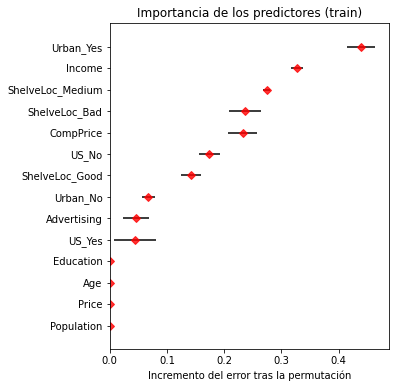

In [27]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))

df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(df_importancia['feature'],
        df_importancia['importances_mean'],
        xerr=df_importancia['importances_std'],
        align='center',
        alpha=0)

ax.plot(df_importancia['importances_mean'],
        df_importancia['feature'],
        marker="D",
        linestyle="",
        alpha=0.8,
        color="r")

ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

Ambas estrategias identifican Urban , Income y ShelveLoc como los predictores más influyentes, acorde a los datos de entrenamiento.